In [1]:
import mitiq
import numpy
from numpy import pi
from cirq import CircuitOperation, CXPowGate, CZPowGate, DensityMatrixSimulator, Simulator, Rx
from cirq.devices.noise_model import GateSubstitutionNoiseModel
from cirq import LineQubit, Circuit, CZ, CNOT, H, Ry, Rz
from cirq import Circuit, LineQubit, H, CNOT, CZ
from functools import partial
import numpy as np
from mitiq import Executor
from mitiq.pt import generate_pauli_twirl_variants
from mitiq.shadows.shadows_utils import fidelity
import cirq
import matplotlib.pyplot as plt

mitiq.SUPPORTED_PROGRAM_TYPES.keys()

['braket', 'pennylane', 'pyquil', 'qiskit']

In [2]:
def circular_ansatz_mirrored(N, reps=1):
    qubits = LineQubit.range(N)
    circuit = Circuit()
    for _ in range(reps):
        for i in range(N):
            circuit.append(cirq.Ry(rads=np.pi/2)(qubits[i]))
        for i in range(N):
            circuit.append(cirq.Rz(rads=np.pi/2)(qubits[i]))
        for i in range(N):
            control = qubits[(i-1) % N]
            target = qubits[i]
            circuit.append(CNOT(control, target))
        for i in range(N):
            circuit.append(cirq.Ry(rads=np.pi/2)(qubits[i]))
        for i in range(N):
            circuit.append(cirq.Rz(rads=np.pi/2)(qubits[i]))
        for i in range(N-1, -1, -1):
            control = qubits[(i-1) % N]
            target = qubits[i]
            circuit.append(CNOT(control, target))
    for i in range(N):
        circuit.append(cirq.Ry(rads=np.pi/2)(qubits[i]))
    for i in range(N):
        circuit.append(cirq.Rz(rads=np.pi/2)(qubits[i]))
    return circuit

def get_noise_model(noise_level: float) -> GateSubstitutionNoiseModel:
    """Substitute each CZ and CNOT gate in the circuit
    with the gate itself followed by an Rx rotation on the output qubits.
    """
    rads = pi / 2 * noise_level
    def noisy_c_gate(op):
        if isinstance(op.gate, (CZPowGate, CXPowGate)):
            return CircuitOperation(
                Circuit(
                    op.gate.on(*op.qubits), 
                    Rx(rads=rads).on_each(op.qubits),
                ).freeze())
        return op

    return GateSubstitutionNoiseModel(noisy_c_gate)

def execute(circuit: Circuit, noise_level: float):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit."""
    return (
        DensityMatrixSimulator(noise=get_noise_model(noise_level=noise_level))
        .simulate(circuit)
        .final_density_matrix
    )

# Set the intensity of the noise
NOISE_LEVEL = 1e-3

In [37]:
def compute_fidelity_improvements():
    results = {}
    for num_qubits in range(3, 11):
        try:
            circuit = circular_ansatz_mirrored(num_qubits, 40)
            # Compute the expectation value of the |0><0| observable
            # in both the noiseless and the noisy setup
            ideal_value = execute(circuit, noise_level=0.0)
            noisy_value = execute(circuit, noise_level=NOISE_LEVEL)
            # Generate twirled circuits
            NUM_TWIRLED_VARIANTS = 100
            twirled_circuits = generate_pauli_twirl_variants(circuit, num_circuits=NUM_TWIRLED_VARIANTS)
            # Average results executed over twirled circuits
            pt_vals = Executor(partial(execute, noise_level=NOISE_LEVEL)).run(twirled_circuits)
            mitigated_result = np.average(pt_vals, axis=0)
            a = cirq.density_matrix(ideal_value, atol=1e-4)
            b = cirq.density_matrix(noisy_value, atol=1e-4)
            c = cirq.density_matrix(mitigated_result, atol=1e-4)

            old_fidelity = cirq.fidelity(a, b, atol=1e-4)
            new_fidelity = cirq.fidelity(a, c, atol=1e-4)
            fidelity_improvement = new_fidelity - old_fidelity
            results[num_qubits]=((old_fidelity, new_fidelity, fidelity_improvement))
            return results
        except:
            break
results = compute_fidelity_improvements()

# print(f"Fidelity Improvement % : {fidelity_improvement*100:.6f}")


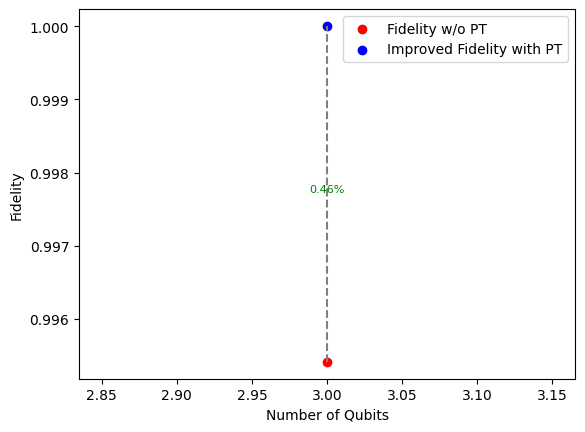

In [38]:
import matplotlib.pyplot as plt

num_qubits = list(results.keys())
old_fidelity = [results[n][0] for n in num_qubits]
new_fidelity = [results[n][1] for n in num_qubits]
fidelity_improvement = [results[n][2] for n in num_qubits]

plt.scatter(num_qubits, old_fidelity, color='red', label='Fidelity w/o PT ')
plt.scatter(num_qubits, new_fidelity, color='blue', label='Improved Fidelity with PT')

for i, n in enumerate(num_qubits):
    plt.plot([n, n], [old_fidelity[i], new_fidelity[i]], color='gray', linestyle='--')
    plt.text(n, (old_fidelity[i] + new_fidelity[i]) / 2, f'{fidelity_improvement[i]*100:.2f}%', 
             ha='center', va='bottom', fontsize=8, color='green')

plt.xlabel('Number of Qubits')
plt.ylabel('Fidelity')
plt.legend()
plt.show()